### This is a project about detecting lane lines on different roads

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Firstly, we need to calibrate our camera!

In [2]:
# a simple demo showing how to find the chess corners of the checkboard picture

%matplotlib inline
filename="camera_cal/calibration2.jpg"
img=cv2.imread(filename)

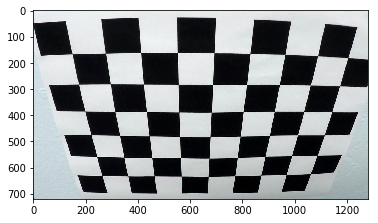

In [3]:
plt.imshow(img)

In [4]:
nx=9
ny=6
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

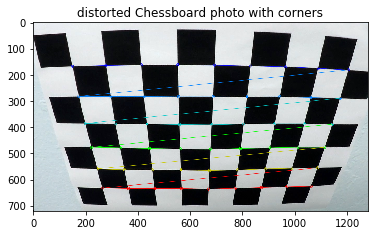

In [5]:
# draw chess corners on the picture:
if ret == True:
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)
    plt.title("distorted Chessboard photo with corners")
    plt.show()

In [6]:
objp = np.zeros((nx*ny,3), np.float32)
objp.shape

(54, 3)

In [7]:
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

In [8]:
import glob
imagefiles=glob.glob('camera_cal/calibration*.jpg')

Firstly, I need to extract all the chess corners from imagefiles so that I can calibrate my cameras!

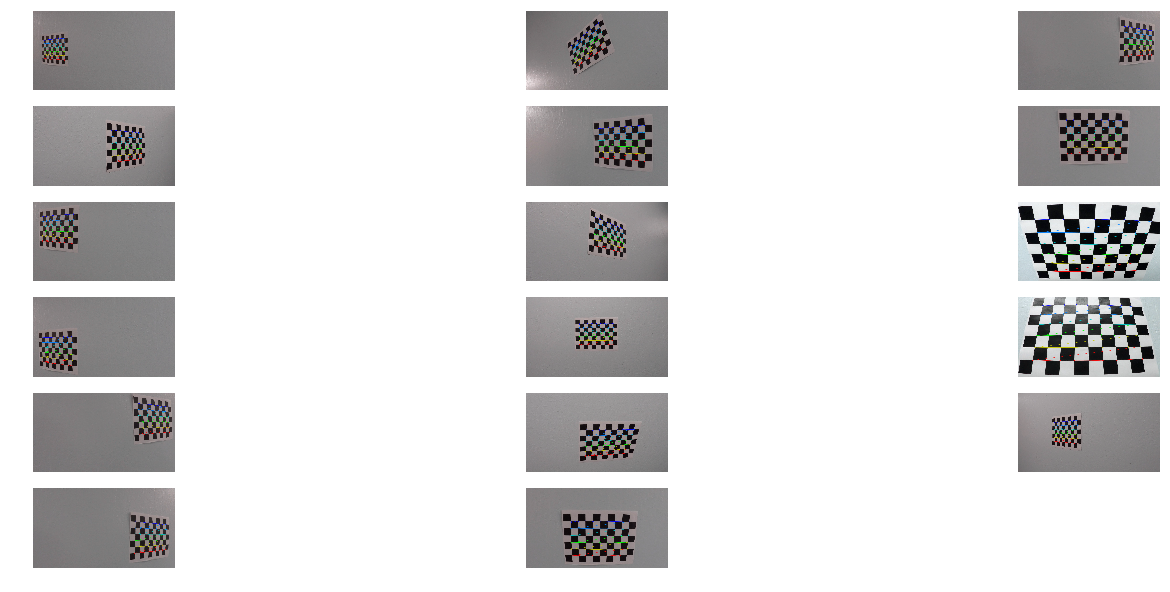

In [9]:
import pylab
pylab.rcParams['figure.figsize'] = (25, 12)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

count=1
for i in range(len(imagefiles)):
    image=cv2.imread(imagefiles[i])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret==True:
        objpoints.append(objp)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
        plt.subplot(7,3,count)
        count+=1
        plt.axis('off')
        plt.imshow(image)
        #plt.show()
        

Then we need to create a undistort functions to undistort my functions

In [10]:
def undistort(image):
    img=image
    #img = mpimg.imread(image)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

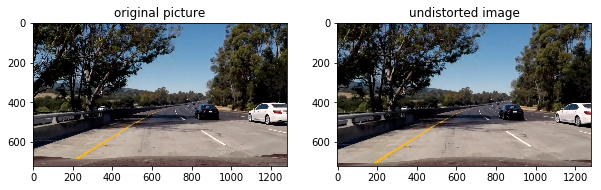

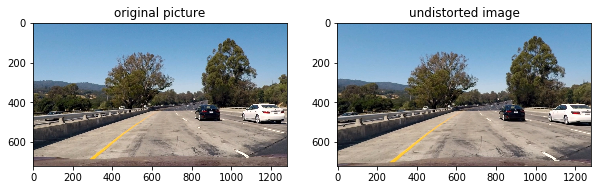

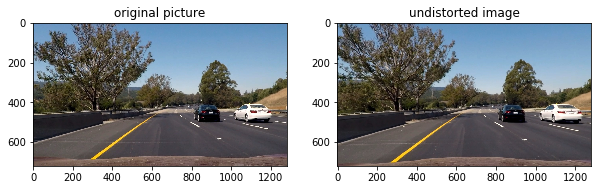

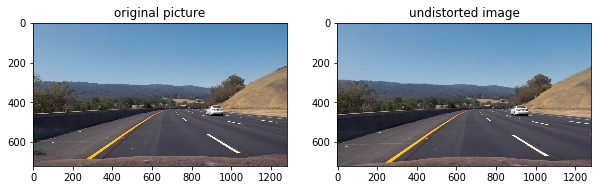

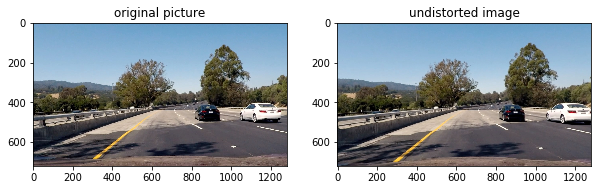

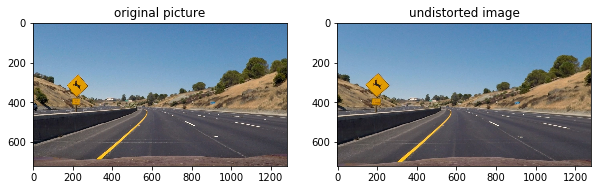

In [11]:
test_images = glob.glob('test_images/test*.jpg')
for image in test_images:
    img=mpimg.imread(image)
    undistortimage=undistort(img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
    #originalimage=mpimg.imread(image)
    ax1.imshow(img)
    ax1.set_title("original picture")
    ax2.imshow(undistortimage)
    ax2.set_title("undistorted image")

### Perspective Transform
Next, I need to transform the pictures above into a bird view so that I can compute the exact location of the lane lines

In [12]:
def warp(img):
    undist=undistort(img)
    img_size=(undist.shape[1],undist.shape[0])
    src = np.float32([[490, 482],[810, 482],[1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped,M

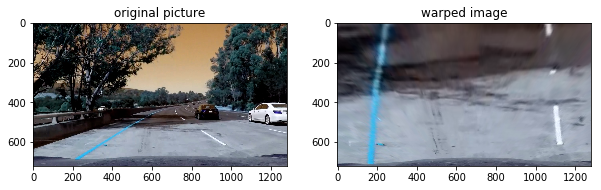

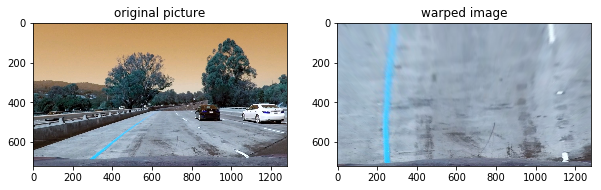

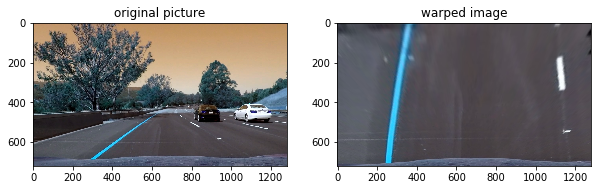

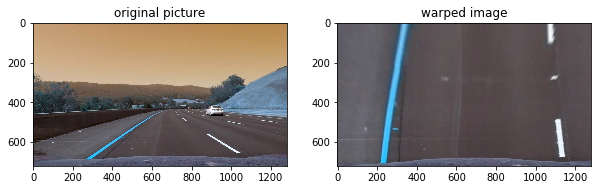

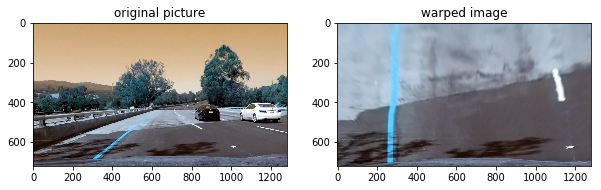

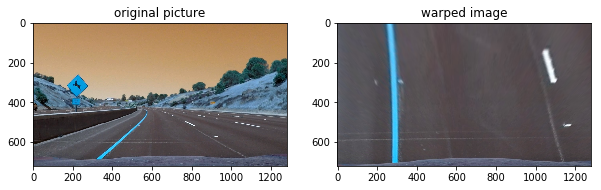

In [13]:
test_images = glob.glob('test_images/test*.jpg')
for imagefile in test_images:
    image=cv2.imread(imagefile)
    warp_image,M=warp(image)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
    #originalimage=cv2.imread(image)
    ax1.imshow(image)
    ax1.set_title("original picture")
    ax2.imshow(warp_image)
    ax2.set_title("warped image")

### Then, we need to create a pipline to transform pictures into a binary-color picturs so that we can detect edges and lines

In [86]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img,M = warp(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    binary_image=np.zeros_like(s_channel)
    binary_image[(s_binary==1)|(sxbinary==1)]=1
    # Convert to grayscale
    #mag_thresh=(30, 100)
    #sobel_kernel=3
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    #sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    #sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    #gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    #scale_factor = np.max(gradmag)/255 
    #gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    #binary_output = np.zeros_like(gradmag)
    #binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    #return binary_output
    #binary_image[(s_binary==1)|(sxbinary==1)|(binary_output==1)]=1
    return binary_image,img,M
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    #return color_binary,img,M

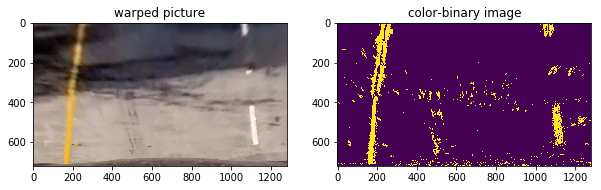

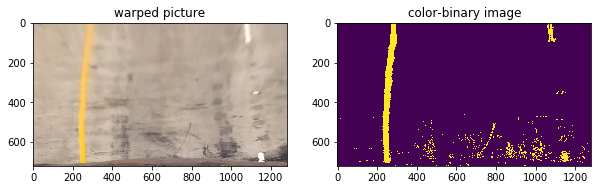

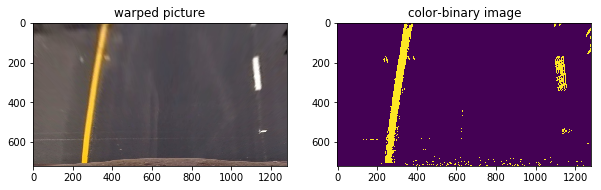

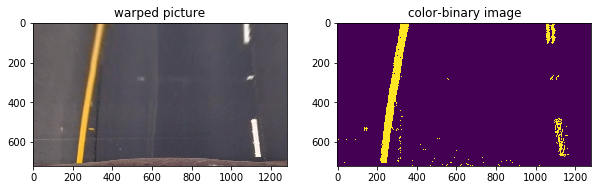

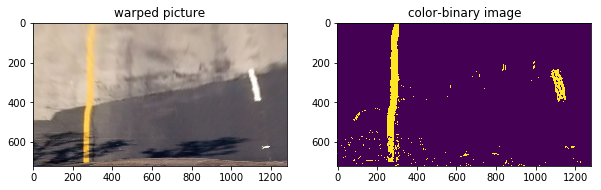

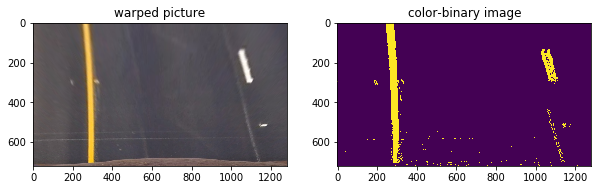

In [87]:
test_images = glob.glob('test_images/test*.jpg')
for imagefile in test_images:
    image=mpimg.imread(imagefile)
    color_binary,warped_image,M=pipeline(image)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
    ax1.imshow(warped_image)
    ax1.set_title("warped picture")
    ax2.imshow(color_binary)
    ax2.set_title("color-binary image")

### Now we need to fit a polynomial to our binary pictures 

In [70]:
def drawpoly(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    #identity non-zero positions
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
          # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])    
    

    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)  
    
    return left_fit,right_fit,left_fitx,right_fitx,ploty,left_curverad,right_curverad

In [71]:
image=cv2.imread("test_images/test3.jpg")
binary_warped,a,b=pipeline(image)
left_fit,right_fit,left_fixx,right_fitx,ploty,cur1,cur2=drawpoly(binary_warped)

In [72]:
#binary_warped,a,b=pipeline("test_images/test3.jpg")
#leftx,lefty=drawpoly(binary_warped)

def fit_lines(binary_warped,draw_picture=False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    global left_fit,right_fit
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])    
    
    # Create an image to draw on and an image to show the selection window
    if draw_picture==True:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    else :
        return left_fit,right_fit,left_fitx,right_fitx,ploty,left_curverad,right_curverad

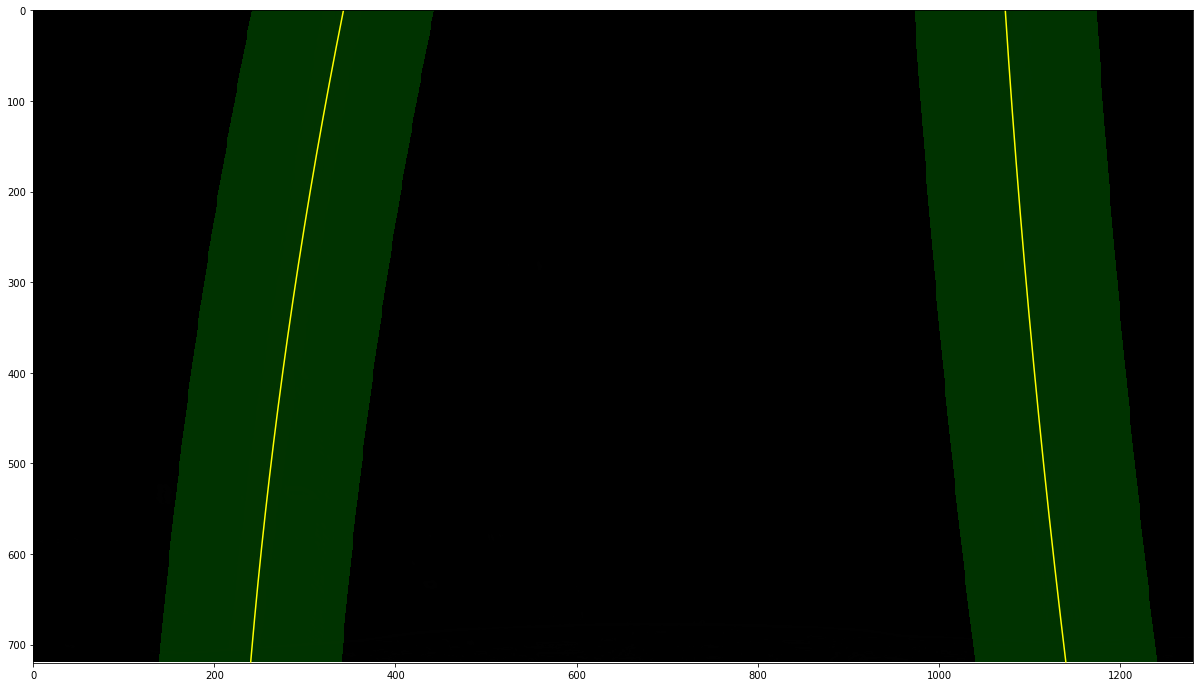

In [73]:
image=mpimg.imread("test_images/test3.jpg")
binary_warped,a,b=pipeline(image)
fit_lines(binary_warped,draw_picture=True)

In [74]:
# referenced from forums about how to find the radius of the circle
def find_3p_circle_radius(x1,y1,x2,y2,x3,y3):
    m1 = (y2-y1)/(x2-x1)
    m2 = (y3-y2)/(x3-x2)
    
    xc = (m1*m2*(y1-y3)+m2*(x1+x2)-m1*(x2+x3))/(2*(m2-m1))
    yc = -(xc-(x1+x2)/2)/m1+(y1+y2)/2
    
    Radius = np.sqrt((x2-xc)*(x2-xc)+(y2-yc)*(y2-yc))
    
    return m1, m2, xc, yc, Radius

In [75]:
def process_image(image):
    img_size = (image.shape[1], image.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    color_binary,warped_image,M=pipeline(image)
    left_fit,right_fit,left_fitx,right_fitx,ploty,left_cur,right_cur=fit_lines(color_binary,draw_picture=False)
    left_intcept= left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    right_intcept= right_fit[0]*720**2+right_fit[1]*720+right_fit[2]
    distance_to_center=abs((left_intcept+right_intcept)/2.0-640)
    
    warp_zero = np.zeros_like(color_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    #plt.imshow(color_binary)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((left_cur+right_cur)/2)), (120,140),fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    cv2.putText(result, 'Vehicle is {:.2f}cm left of center'.format(distance_to_center), (100,80),fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    return result

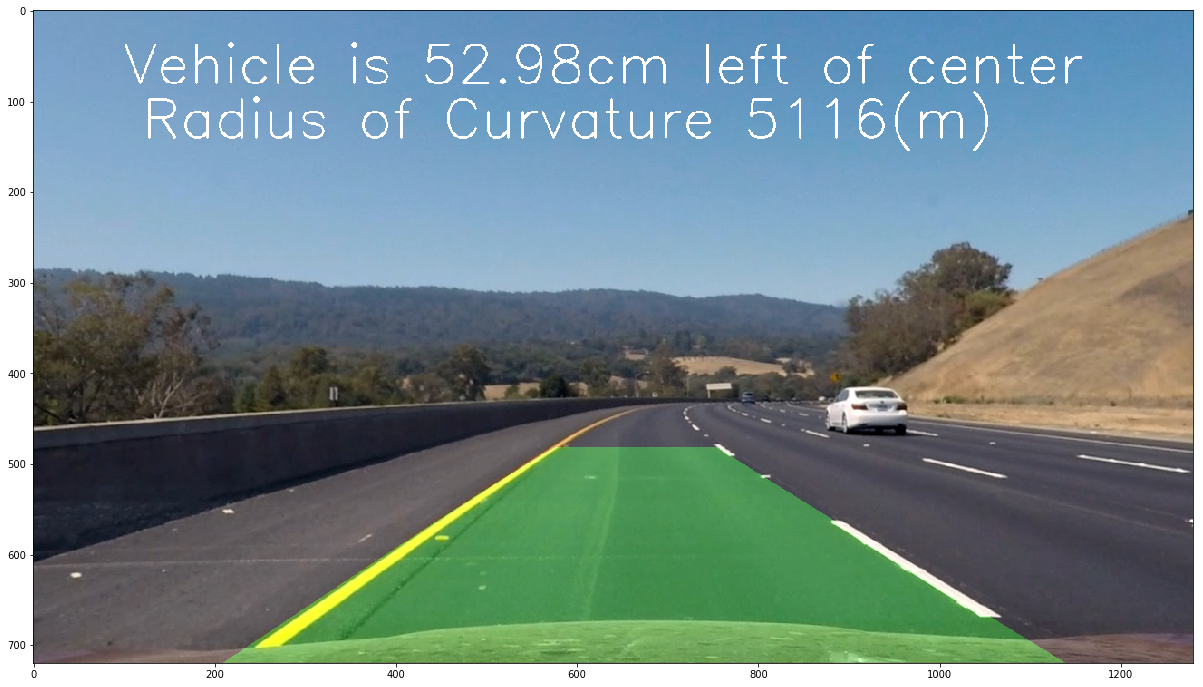

In [77]:
Test_image=mpimg.imread("test_images/test3.jpg")
#process_image(Test_image)
plt.imshow(process_image(Test_image))

In [78]:
Test_image.shape

(720, 1280, 3)

In [29]:
from moviepy.editor import VideoFileClip
video_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [49:19<00:02,  2.32s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



In [30]:
image=cv2.imread("test_images/test3.jpg")
binary_warped,a,b=pipeline(image)
left_fit,right_fit,left_fixx,right_fitx,ploty,cur1,cur2=drawpoly(binary_warped)

In [46]:
video_output = 'result_demo.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image).subclip(0,2)
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result_demo.mp4
[MoviePy] Writing video result_demo.mp4


 98%|█████████▊| 50/51 [01:54<00:02,  2.29s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_demo.mp4 



In [79]:
image=mpimg.imread("test_images/test4.jpg")
color_binary,warped_image,M=pipeline(image)
left_fit,right_fit,left_fitx,right_fitx,ploty,left_cur,right_cur=drawpoly(color_binary)

In [80]:
img_size = (image.shape[1], image.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
undist = cv2.undistort(image, mtx, dist, None, mtx)
offset = 0
src = np.float32([[490, 482],[810, 482],[1250, 720],[0, 720]])
dst = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])
Minv = cv2.getPerspectiveTransform(dst, src)
check=False
def process_image_2(image):    
    img_size = (image.shape[1], image.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    offset = 0
    src = np.float32([[490, 482],[810, 482],[1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    color_binary,warped_image,M=pipeline(image)
    left_fit,right_fit,left_fitx,right_fitx,ploty,left_cur,right_cur=drawpoly(color_binary)
    left_intcept= left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    right_intcept= right_fit[0]*720**2+right_fit[1]*720+right_fit[2]
    distance_to_center=abs((left_intcept+right_intcept)/2.0-640)
    
    warp_zero = np.zeros_like(color_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    #plt.imshow(color_binary)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((left_cur+right_cur)/2)), (120,140),fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    cv2.putText(result, 'Vehicle is {:.2f}cm left of center'.format(distance_to_center), (100,80),fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    return result

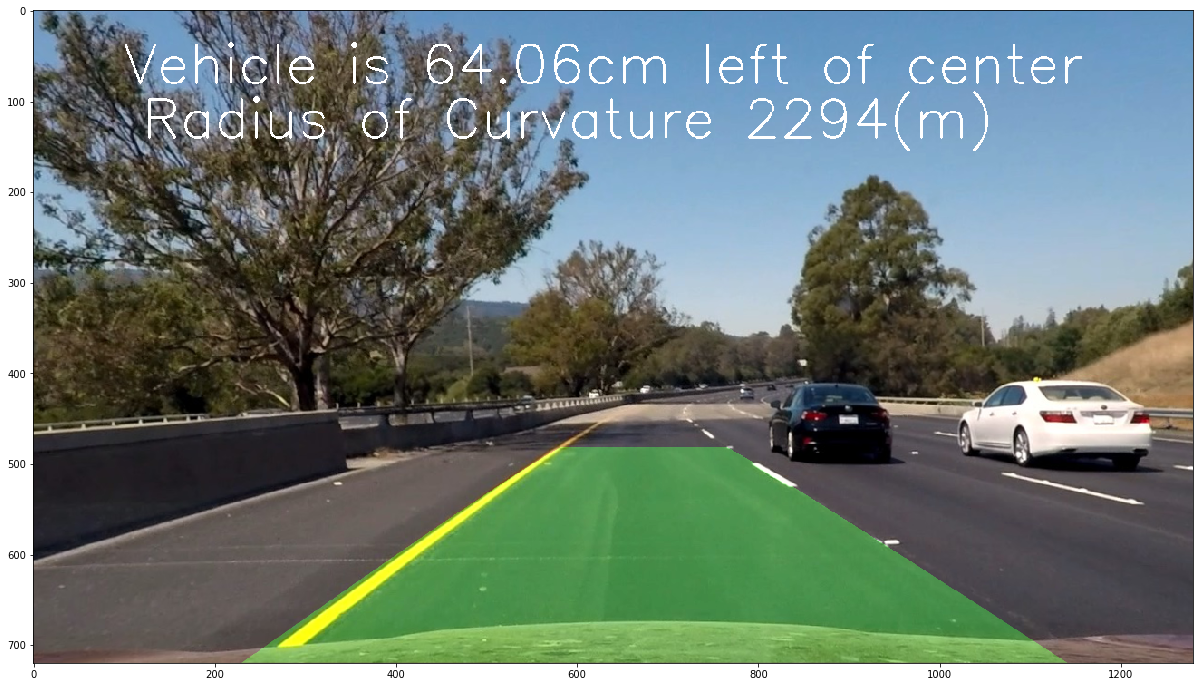

In [81]:
Test_image=mpimg.imread("test_images/test6.jpg")
#process_image(Test_image)
plt.imshow(process_image_2(Test_image))

In [88]:
from moviepy.editor import VideoFileClip
video_output = 'result_test.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image_2).subclip(47,49)
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result_test.mp4
[MoviePy] Writing video result_test.mp4


 98%|█████████▊| 50/51 [01:55<00:02,  2.31s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_test.mp4 



In [ ]:
from moviepy.editor import VideoFileClip
video_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) 
white_clip.write_videofile(video_output, audio=False)